## Цель и задачи проекта

Целью данного проекта является создание модели, которая способна выявлять абонентов, планирующих отказаться от услуг связи компании «ТелеДом», на основе персональных данных абонентов, информации об их тарифах и услугах.

Перед началом исследования мы подключимся к базе данных и прочитаем все необходимые датасеты. Мы проверим каждый датасет на наличие пропусков и аномалий. Далее мы объединим все наши таблицы по идентификатору клиента и создадим целевую переменную (факт ухода абонента), а также создадим новые признаки.

В исследовательском анализе данных мы изучим распределения и проведем анализ каждого признака с помощью графиков. Мы также визуализируем соотношения оставшихся и ушедших клиентов. Также, мы проведем корреляционный анализ целевого и входных признаков.

Перед началом обучения необходимо будет разделить наш финальный датасет на тренировочную и тестовую выборку, закодировать категориальные и стандартизировать количественные входные признаки. Наш целевой признак - факт ухода абонента, поэтому мы решаем проблему классификациии. Для поиска лучшей модели на основе кросс-валидации мы будем использовать пайплайн и RandomizedSearchCV, который будет перебирать наилучшие гиперпараметры у нескольких моделей классификации. Для оценки качества модели мы будем использовать метрику ROC AUC.

Мы проверим качество лучшей модели на тестовой выборке, выведем дополнительные метрики (recacll, precision, accuracy), построим матрицу ошибок и оценим ее результаты. Также будут проанализированы самые важные признаки для нашей модели. Далее мы построим график зависимости одного важного признака от целевой переменной.

В конце исследования будут сформированы ключевые выводы по результатам анализа и обучения модели, будут даны рекомендации по использованию модели в бизнесс процессах и предложены пути улучшения модели.

## Загрузка и чтение данных

In [1]:
!wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db
!pip install phik -q
!pip install sqlalchemy -q
!pip install lightgbm -q

--2025-01-28 18:00:17--  https://code.s3.yandex.net/data-scientist/ds-plus-final.db
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3588096 (3.4M) [application/octet-stream]
Saving to: ‘ds-plus-final.db.4’

ds-plus-final.db.4  100%[===================>]   3.42M  11.0MB/s    in 0.3s    

2025-01-28 18:00:18 (11.0 MB/s) - ‘ds-plus-final.db.4’ saved [3588096/3588096]



In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from math import ceil
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
from sqlalchemy import create_engine,inspect
from phik.report import plot_correlation_matrix

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split,RandomizedSearchCV,KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import HistGradientBoostingClassifier,GradientBoostingClassifier
from sklearn.metrics import (precision_recall_curve, confusion_matrix,
                             precision_score, auc, accuracy_score,
                             recall_score, roc_auc_score, roc_curve)

In [3]:
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)
RANDOM_STATE = 200125
TEST_SIZE = 0.25

In [4]:
def sql_func(text):
    query = text
    df = pd.read_sql_query(query, con=engine)
    return df

In [5]:
def isna_duplicated(df,df_name):
    print(f'Кол-во дубликатов в датасете с {df_name}: {df.duplicated().sum()}')
    print(f'Кол-во пропусков в датасете с  {df_name}: \n{df.isna().sum()}')

In [6]:
inspection = inspect(engine)
print(f'Название таблиц в базе данных {inspection.get_table_names()}')

Название таблиц в базе данных ['contract', 'data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time', 'internet', 'personal', 'phone']


Для нашего проекта необходимы только четыре датасета - contract, internet, personal и phone.

In [7]:
df_contract = sql_func('''SELECT *
                          FROM contract''')

In [8]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


In [9]:
df_contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.1,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.8,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


Данный датасет  содержит информацию о начале / конце (если он есть) договоров у клиентов оператора связи, а также типах этих договоров, отправки счета и оплаты, сумме месячной оплаты и общей сумме расходов клиента .


Мы видим три категориальных признака (type, paperless billing, payment moment), два количественных (monthly charges, total charges), и два признака с датами (begin / end date).

Необходимо будет привести все названия столбцов к нижнему регистру и добавить нижнее подчеркивание, также изменить тип данных у количественных столбцов и столбцов с датой.

In [10]:
df_contract.rename(columns={"customerID": "customer_id", "BeginDate": "begin_date",'EndDate':'end_date',
                            'Type':'type', 'PaperlessBilling': 'paperless_billing','PaymentMethod':'payment_method',
                            'MonthlyCharges':'monthly_charges','TotalCharges':'total_charges'}, inplace=True)

In [11]:
sql_func('''SELECT *
FROM contract
ORDER BY totalcharges 
LIMIT 15
''')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
1,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
2,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
3,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
4,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
5,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
6,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
7,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.0,
8,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.7,
9,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [12]:
customer_id_with_null= sql_func('''SELECT customerID
                                  FROM contract
                                  ORDER BY totalcharges 
                                  LIMIT 11
                               ''')

Мы не можем изменить тип данных у столбца total_charges из-за пустых строк. Пустое значение total charges мы видим только у тех пользователей, чей договор начал действовать в день выгрузки датасета. То есть этим абонентам еще не пришел счет за услуги. Эти 11 строк мы можем спокойно удалить.

In [13]:
customer_id_with_null

,customerID
0,4472-LVYGI
1,3115-CZMZD
2,5709-LVOEQ
3,4367-NUYAO
4,1371-DWPAZ
5,7644-OMVMY
6,3213-VVOLG
7,2520-SGTTA
8,2923-ARZLG
9,4075-WKNIU


Мы не можем изменить тип данных у столбца total_charges из-за пустых строк. Пустое значение total charges мы видим только у тех пользователей, чей договор начал действовать в день выгрузки датасета. То есть этим абонентам еще не пришел счет за услуги. Будет логично заменить пропуски на нулевые значения.

In [15]:
df_contract.loc[df_contract['customer_id'].isin(customer_id_with_null.values.flatten()), 'total_charges'] = 0

In [16]:
df_contract[df_contract['customer_id'] == '2923-ARZLG']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.7,0


In [17]:
df_contract.reset_index(drop=True, inplace=True)

In [18]:
for col in ['monthly_charges','total_charges']:
    df_contract[col] = df_contract[col].astype('float32')

In [19]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float32
 7   total_charges      7043 non-null   float32
dtypes: float32(2), object(6)
memory usage: 385.3+ KB


Мы успешно изменили тип данных у количественных столбцов.

In [20]:
isna_duplicated(df_contract, 'договорами')

Кол-во дубликатов в датасете с договорами: 0
Кол-во пропусков в датасете с  договорами: 
customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64


In [21]:
for el in df_contract.columns:
    print(df_contract[el].unique())

['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '2015-08-01' '2015-11-01' '2014-06-01' '201

Мы не видим лишних значений у категориальных столбцов. В данных представлены клиенты, которые заключили договор с компанией с 2013 по 2020 год.

Изменим тип данных у столбцов с датой.

In [22]:
df_contract['end_date'].value_counts()

end_date
No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2015-04-01       2
2014-12-01       2
2014-10-01       1
2014-06-01       1
2014-11-01       1
Name: count, Length: 67, dtype: int64

Большинство клиентов (5931 из 7032) все еще пользуются услугами оператора связи. Было принято изменить значение 'No' на дату выгрузки датасета.

In [25]:
df_contract.head(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850000,31.040001
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950001,2071.840088
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.849998,226.169998
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.299999,1960.599976
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.699997,353.500000


In [27]:
df_contract['begin_date'] = df_contract['begin_date'].astype('datetime64[ns]')

In [28]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float32       
 7   total_charges      7043 non-null   float32       
dtypes: datetime64[ns](1), float32(2), object(5)
memory usage: 385.3+ KB


Тип данных успешно изменен.

In [29]:
df_personal = sql_func('''SELECT *
                          FROM personal''')

In [30]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


In [31]:
df_personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [32]:
df_personal.rename(columns={"customerID": "customer_id", "SeniorCitizen": "senior_citizen",'Partner':'partner',
                            'Dependents':'dependents'}, inplace=True)

Данный датасет содержит информацию об абонентах - пол, является ли абонент пенсионером, есть ли у абонента супруг или супруга или дети. Все признаки категориальные.

In [33]:
isna_duplicated(df_personal, 'персональными данными клиентов')

Кол-во дубликатов в датасете с персональными данными клиентов: 0
Кол-во пропусков в датасете с  персональными данными клиентов: 
customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64


In [34]:
for el in df_personal.columns:
    print(df_personal[el].unique())

['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
['Female' 'Male']
['0' '1']
['Yes' 'No']
['No' 'Yes']


Мы не видим аномальных значений, пропусков или аномалий.

In [35]:
print(f'Количество уникальных клиентов в df_personal - {df_personal["customer_id"].nunique()}')

Количество уникальных клиентов в df_personal - 7043


In [36]:
df_internet = sql_func('''SELECT *
                          FROM internet''')

In [37]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Таблица internet

customerID — ID пользователя;

InternetService — тип подключения;

OnlineSecurity — блокировка опасных сайтов;

OnlineBackup — облачное хранилище файлов для резервного копирования данных;

DeviceProtection — антивирус;

TechSupport — выделенная линия технической поддержки;

StreamingTV — стриминговое телевидение;

StreamingMovies — каталог фильмов.

In [38]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [39]:
df_internet.rename(columns={"customerID": "customer_id", "InternetService": "internet_service",
                            'OnlineBackup':'online_backup','DeviceProtection':'device_protection',
                            'OnlineSecurity':'online_security', 'TechSupport':'tech_support',
                           'StreamingTV':'streaming_tv','StreamingMovies':'streaming_movies'}, inplace=True)

In [40]:
isna_duplicated(df_internet, 'информацией об интернет-услугах')

Кол-во дубликатов в датасете с информацией об интернет-услугах: 0
Кол-во пропусков в датасете с  информацией об интернет-услугах: 
customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64


In [41]:
for el in df_internet.columns:
    print(df_internet[el].unique())

['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
['DSL' 'Fiber optic']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']


Все признаки категориальные, без аномальных значений.

In [42]:
print(f'Количество уникальных клиентов в df_internet - {df_internet["customer_id"].nunique()}')

Количество уникальных клиентов в df_internet - 5517


Мы видим, чтол количество уникальных клиентов в данном датасете почти на 1 500 меньше, чем в датасетах с договорами и абонентами. Можно сделать вывод, что данный датасет содержит информацию только о тех клиентах, чье устройство имеет доступ к интернету.

In [43]:
df_phone = sql_func('''SELECT *
                          FROM phone''')

In [44]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerId     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [45]:
df_phone.head()

,CustomerId,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Данный датасет показывает факт подключения телефона абонента к нескольким линиям одновременно. Только один категориальный признак.

In [46]:
df_phone.rename(columns={"CustomerId": "customer_id", "MultipleLines": "multiple_lines"}, inplace=True)

In [47]:
isna_duplicated(df_phone, 'информацией об услугах телефонии')

Кол-во дубликатов в датасете с информацией об услугах телефонии: 0
Кол-во пропусков в датасете с  информацией об услугах телефонии: 
customer_id       0
multiple_lines    0
dtype: int64


In [48]:
for el in df_phone.columns:
    print(df_phone[el].unique())

['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
['No' 'Yes']


Аномальных значений нет.

In [49]:
print(f'Количество уникальных клиентов в df_phone - {df_phone["customer_id"].nunique()}')

Количество уникальных клиентов в df_phone - 6361


В данном датасете также меньше уникальных пользователей, чем в первых двух. Отсутсвие еще ~700 абонентов в данном датасете может указывать на то, что у этих клиентов нет телефона.

Мы загрузили и проверили корректность всех датасетов. Для исследования мы будем использовать таблицы с информацией о договорах, абонентах, описании их интернет-услуг и об услугах телефонии. Каждый из четырех датасетов мы проверили на наличие пропусков, аномалий, а также обработали их при необходимости. Мы отредактировали названия столбцов и изменили тип данных, там где это было необходимо. Мы выяснили, что в датасетах с интернет услугами и услугами стационарной связи меньше уникальных клиентов, чем в остальных. Это означает, что у части абонентов нет интернета / телефона. Это будет учитываться при объединении всех таблиц в одну.

## Объединение таблиц

In [50]:
#объединяем все четыре таблицы в одну по customer_id
df = df_contract.merge(df_personal, on='customer_id')
df = df.merge(df_internet, how='left', on='customer_id')
df = df.merge(df_phone, how='left', on='customer_id')

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float32       
 7   total_charges      7043 non-null   float32       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

In [52]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850000,31.040001,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950001,2071.840088,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.849998,226.169998,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.299999,1960.599976,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.699997,353.500000,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [53]:
print(f'Кол-во уникальных абонентов - {df["customer_id"].shape[0]}')

Кол-во уникальных абонентов - 7043


В нашем финальном датасете содержится информация о 7043 уникальных клиентах.

In [54]:
#удаляем столбец с айди, так как он нам больше не нужен
df.drop('customer_id',inplace=True, axis=1)

In [55]:
df.isna().sum()

begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

Мы видим большое количество пропусков в столбцах связанных с интернетом, можно сделать вывод, что эти пропуски означают отсутствие интернета, а пропуски в столбце multiple_lines означают отсутствие телефона. Заменим все пропуски на 'no_internet' и 'no_phone' соответственно.

In [56]:
columns_with_isna = ['internet_service', 'online_security',
                     'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
                     'streaming_movies']

In [57]:
df[columns_with_isna] = df[columns_with_isna].fillna('no_internet')
df['multiple_lines'] = df['multiple_lines'].fillna('no_phone')

In [58]:
df.isna().sum()

begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

In [59]:
df['streaming_tv'].value_counts()

streaming_tv
No             2810
Yes            2707
no_internet    1526
Name: count, dtype: int64

In [60]:
df['multiple_lines'].value_counts()

multiple_lines
No          3390
Yes         2971
no_phone     682
Name: count, dtype: int64

Создадим нашу целевую переменную - факт оттока клиента по столбцу end_date. Если в столбце указана дата окончания договора (кроме даты выгрузки датасета), то данный клиент считается ушедшим (значение = 1).

In [62]:
df['target'] = df['end_date'].astype(str).apply(lambda x: 0 if x == 'No' else 1)

In [63]:
df.loc[df['end_date'] == 'No', 'end_date'] = '2020-02-01'
df['end_date'] = df['end_date'].astype('datetime64[ns]')

In [64]:
df.head(5)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target
0,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.850000,31.040001,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_phone,0
1,2017-04-01,2020-02-01,One year,No,Mailed check,56.950001,2071.840088,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
2,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.849998,226.169998,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0
3,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.299999,1960.599976,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_phone,0
4,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.699997,353.500000,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0


In [65]:
df['target'].value_counts()

target
0    5942
1    1101
Name: count, dtype: int64

Мы видим, что в датасете присутствует дисбаланс классов целевого признака. Это будет учтено при разделении выборки на тренировочную/тестовую и при указании парамтеров моделей классификации.

Создадим новый признак - количество дней длительности договора, так как в нашем случае не стоит использовать столбцы с датами в обучении модели.

In [66]:
df['length'] = (df['end_date'] - df['begin_date']).dt.days

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float32       
 6   total_charges      7043 non-null   float32       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   object        
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   7043 non-null   object        
 12  online_security    7043 non-null   object        
 13  online_backup      7043 non-null   object        
 14  device_p

In [68]:
df.head(5)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,length
0,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.850000,31.040001,Female,0,Yes,...,DSL,No,Yes,No,No,No,No,no_phone,0,31
1,2017-04-01,2020-02-01,One year,No,Mailed check,56.950001,2071.840088,Male,0,No,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.849998,226.169998,Male,0,No,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.299999,1960.599976,Male,0,No,...,DSL,Yes,No,Yes,Yes,No,No,no_phone,0,1371
4,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.699997,353.500000,Female,0,No,...,Fiber optic,No,No,No,No,No,No,No,0,153


Мы объединили все датасеты по customer_id, в финальный датасет попали все 7043 уникальных абонента. Пропуски для клиентов с отсутствием интернета или телефона мы заполнили строкой 'no_internet' / 'no_phone'. Был создан целевой признак из значения в end_date, а также добавлен новый входной признак с разницей между окончанием и созданием договора в днях. Мы удалили столбец с идентификатором клиента, так как он полностью совпадает по длине с индексом. Мы избавились от дубликатов, обновили индексы, теперь наш финальный датасет готов к исследовательскому и корреляционному анализу.

## Исследовательский анализ данных

In [73]:
def hist_and_box(column,label_x, label_hist):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(column, ax=ax_box)
    sns.histplot(column, ax=ax_hist)
    ax_box.set(xlabel='')
    ax_hist.set(xlabel=label_x)
    plt.title(label_hist)
    plt.ylabel('Количество')

In [74]:
def pivot_pie(df, index, values, aggfunc, name):
    pivot_table = pivot(df, index, values, aggfunc).sort_values(by='begin_date',ascending=False)
    pie_graph = pie(pivot_table[values], pivot_table.index,name)
    return pivot_table, pie_graph

In [75]:
def pie(numbers, labels, title):
    subs_pivot = numbers
    fig, ax = plt.subplots()
    ax.pie(subs_pivot, labels = labels, shadow=True, autopct='%1.0f%%')
    plt.title(title);

In [76]:
def pivot(df,index, values, aggfunc):
    return df.pivot_table(index=index, values = values, aggfunc = aggfunc)

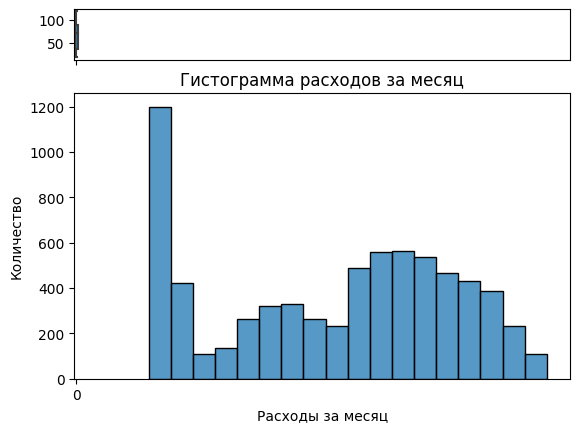

In [77]:
hist_and_box(df['monthly_charges'],'Расходы за месяц','Гистограмма расходов за месяц')

In [78]:
df['monthly_charges'].describe()

count    7043.000000
mean       64.761696
std        30.089973
min        18.250000
25%        35.500000
50%        70.349998
75%        89.849998
max       118.750000
Name: monthly_charges, dtype: float64

Мы видим, что у большинства клиентов месячные расходы составляет от 18 до 25 единиц. Также, большая часть клиентов платят от 70 до 110 в месяц. Среднее значение расходов - 64, медиана чуть больше - 70, это связано с наличием пользователей с низкими расходами, которые смещают среднее вниз. Стандартное отклонение - 30 - указывает на сильный разброс и значительные различия в расходах пользователей.

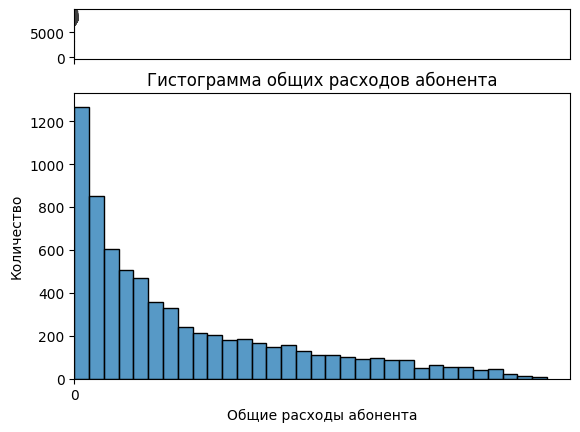

In [79]:
hist_and_box(df['total_charges'],'Общие расходы абонента','Гистограмма общих расходов абонента')

In [80]:
df['total_charges'].describe()

count    7043.000000
mean     2115.312744
std      2112.741943
min         0.000000
25%       436.750000
50%      1343.349976
75%      3236.689941
max      9221.379883
Name: total_charges, dtype: float64

Гистограмма показывает, что общие расходы абонента у большинства клиентов не превышает 1000. В данных присутствуют выбросы - совсем немного клиентов в общей сумме заплатили больше 7500.

Так как мы видим ненормальное распределение, будем опираться на значение медианы - 1345, половина абонентов потратила менее этой суммы. Стандартное отклонение 2111 указывает на большой разброс данных, что свидетельствует о значительных различиях в продолжительности использования услуг или тарифах. Максимальное значение — 9221.38, что указывает на клиентов с длительным сроком обслуживания или высоким уровнем потребления услуг

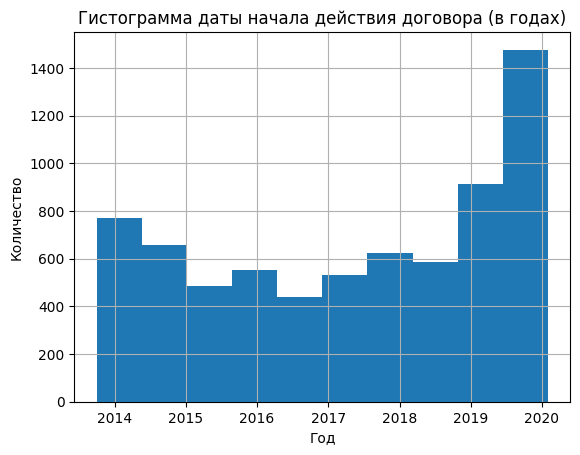

In [81]:
df['begin_date'].hist()
plt.title('Гистограмма даты начала действия договора (в годах)')
plt.xlabel('Год')
plt.ylabel('Количество');

Мы видим, что начиная с 2017 года количество новых пользователей только увеличивалось - мы видим, что во второй половине 2020 года пик новых клиентов. 

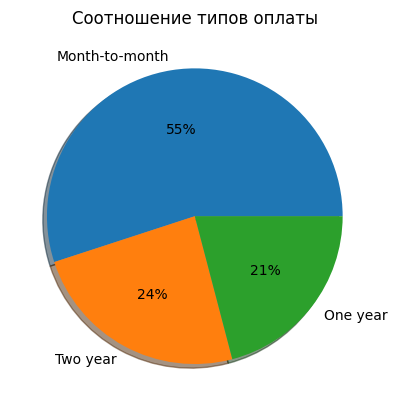

In [82]:
pivot_type,pie_type = pivot_pie(df, 'type','begin_date','count','Соотношение типов оплаты')

In [83]:
pivot_type

,begin_date
type,
Month-to-month,3875
Two year,1695
One year,1473


Более половины клиентов оплачивают услуги ежемесячно, примерно одинаковое количество клиентов (25%) делают это раз в один / два года.

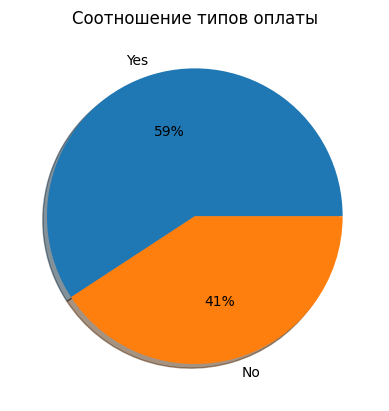

In [84]:
pivot_billing,pie_billing = pivot_pie(df, 'paperless_billing','begin_date','count','Соотношение типов оплаты')

In [85]:
pivot_billing

,begin_date
paperless_billing,
Yes,4171
No,2872


Практически 60% абонентов получают электронный расчетный лист.

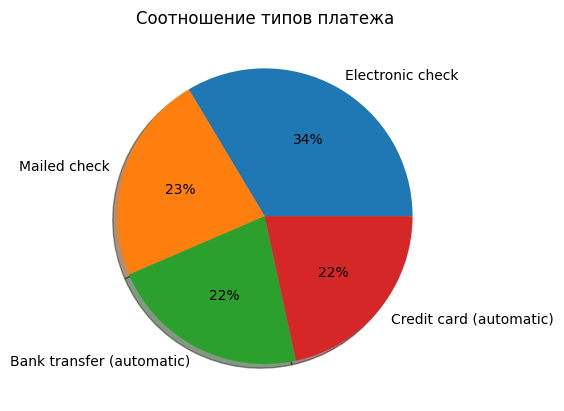

In [86]:
pivot_pay_method,pie_pay_method = pivot_pie(df, 'payment_method',
                                            'begin_date','count','Соотношение типов платежа')

In [87]:
pivot_pay_method

,begin_date
payment_method,
Electronic check,2365
Mailed check,1612
Bank transfer (automatic),1544
Credit card (automatic),1522


Большинство клиентов оплачивают услуги через электронный чек, одинаковое количество абонентов используют автоплатеж, оплачивают услуги банковским переводом и через физический чек.

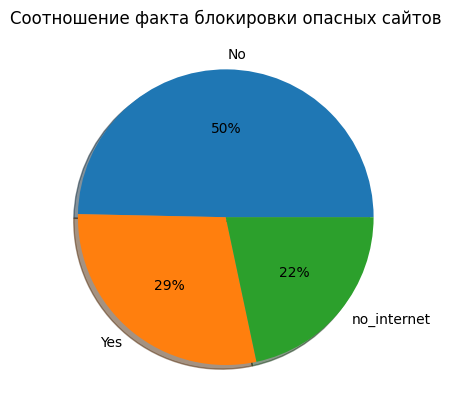

In [88]:
pivot_security, pie_security = pivot_pie(df, 'online_security','begin_date','count',
                          'Соотношение факта блокировки опасных сайтов')

In [89]:
pivot_security

,begin_date
online_security,
No,3498
Yes,2019
no_internet,1526


Половина людей не имеют функции блокировки опасных сайтов.

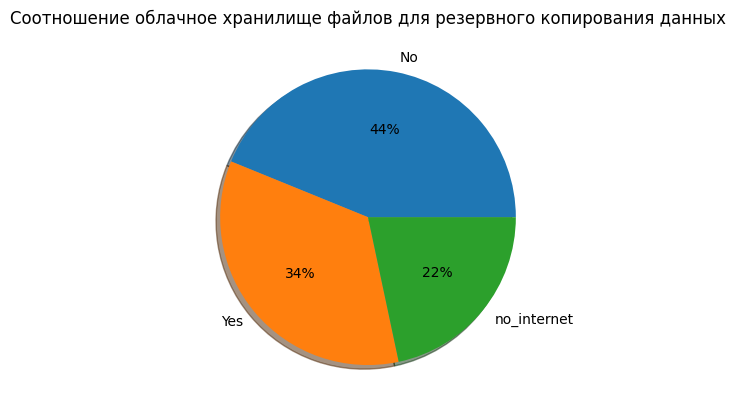

In [90]:
pivot_backup, pie_backup = pivot_pie(df, 'online_backup','begin_date','count',
                          'Соотношение облачное хранилище файлов для резервного копирования данных')

In [91]:
pivot_backup

,begin_date
online_backup,
No,3088
Yes,2429
no_internet,1526


Большинство клиентов не пользуются облачным хранилищем для резервного копирования.

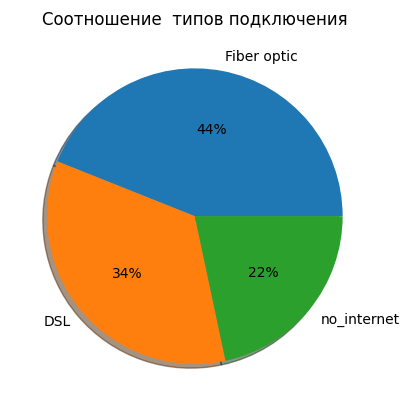

In [92]:
pivot_internet, pie_internet = pivot_pie(df, 'internet_service','begin_date','count',
                          'Соотношение  типов подключения')

In [93]:
pivot_internet

,begin_date
internet_service,
Fiber optic,3096
DSL,2421
no_internet,1526


Тип подключения большинства клиентов - оптическое волокно.

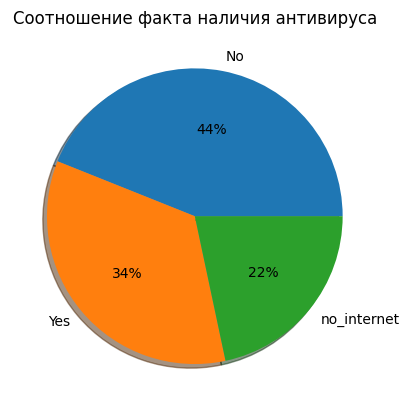

In [94]:
pivot_protection, pie_protection = pivot_pie(df, 'device_protection','begin_date','count',
                          'Соотношение факта наличия антивируса')

In [95]:
pivot_protection

,begin_date
device_protection,
No,3095
Yes,2422
no_internet,1526


Большинство клиентов не пользуются услугами антивируса.

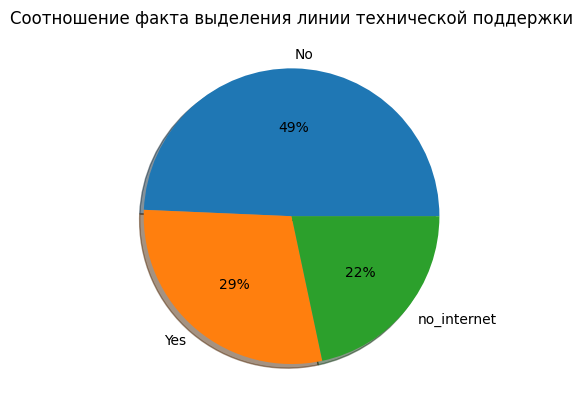

In [96]:
pivot_support, pie_support = pivot_pie(df, 'tech_support','begin_date','count',
                          'Соотношение факта выделения линии технической поддержки')

In [97]:
pivot_support

,begin_date
tech_support,
No,3473
Yes,2044
no_internet,1526


Половина клиентов не имеет выделенную линию технической поддержки.

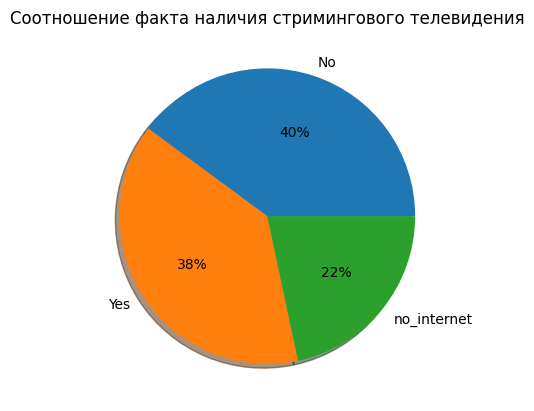

In [98]:
pivot_tv, pie_tv = pivot_pie(df, 'streaming_tv','begin_date','count',
                          'Соотношение факта наличия стримингового телевидения')

In [99]:
pivot_tv

,begin_date
streaming_tv,
No,2810
Yes,2707
no_internet,1526


Практически одинаковое количество абонентов (40% и 38% соответственно) пользуются и не пользуются услугой стримингового телевидения.

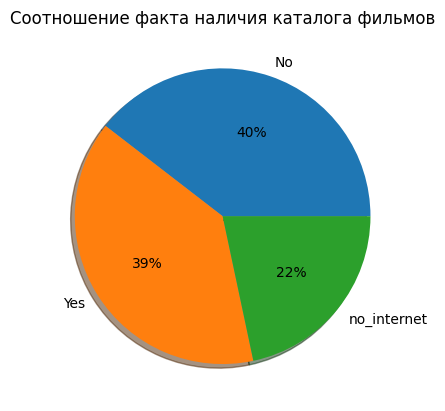

In [100]:
pivot_movies, pie_movies = pivot_pie(df, 'streaming_movies','begin_date','count',
                          'Соотношение факта наличия каталога фильмов')

In [101]:
pivot_movies

,begin_date
streaming_movies,
No,2785
Yes,2732
no_internet,1526


Как и со стриминговым телевидением, практически одинаковое количество абонентов имеют / не имеют доступ к катологу фильмов. По всем графикам связанных с описанием интернет услуг мы видим, что 22% от общего числа клиентов не имеют устройства / тарифа с интернетом.

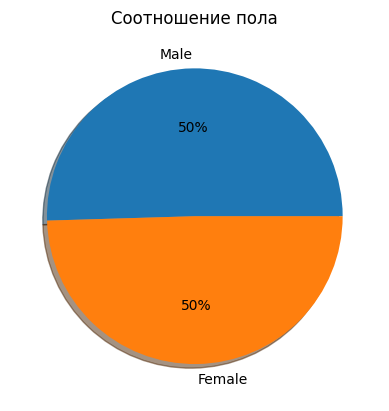

In [102]:
pivot_gender, pie_gender = pivot_pie(df, 'gender','begin_date','count',
                          'Соотношение пола')

In [103]:
pivot_gender

,begin_date
gender,
Male,3555
Female,3488


Среди абонентов оператора связи одинаковое количество мужчин и женщин.

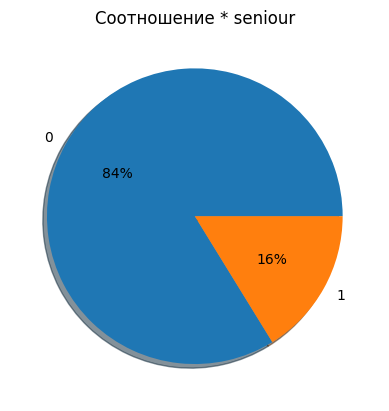

In [104]:
pivot_senior, pie_senior = pivot_pie(df, 'senior_citizen','begin_date','count',
                          'Соотношение * seniour')

In [105]:
pivot_senior

,begin_date
senior_citizen,
0,5901
1,1142


Только 16% абонентов являются пенсионерами.

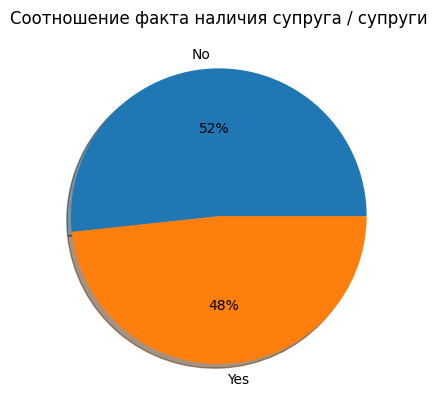

In [106]:
pivot_partner, pie_partner = pivot_pie(df, 'partner','begin_date','count',
                          'Соотношение факта наличия супруга / супруги')

In [107]:
pivot_partner

,begin_date
partner,
No,3641
Yes,3402


Практически одинаковое количество клиентов состоят и не состоят в браке.

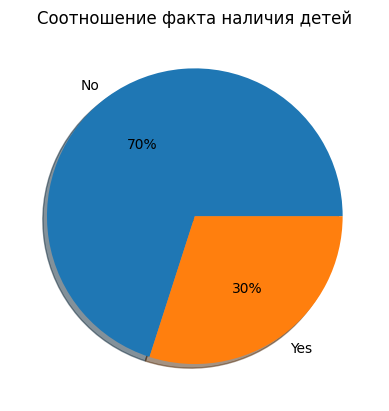

In [108]:
pivot_dependents, pie_dependents = pivot_pie(df, 'dependents','begin_date','count',
                          'Соотношение факта наличия детей')

In [109]:
pivot_dependents

,begin_date
dependents,
No,4933
Yes,2110


Большинство клиентов, 70%, имеют детей.

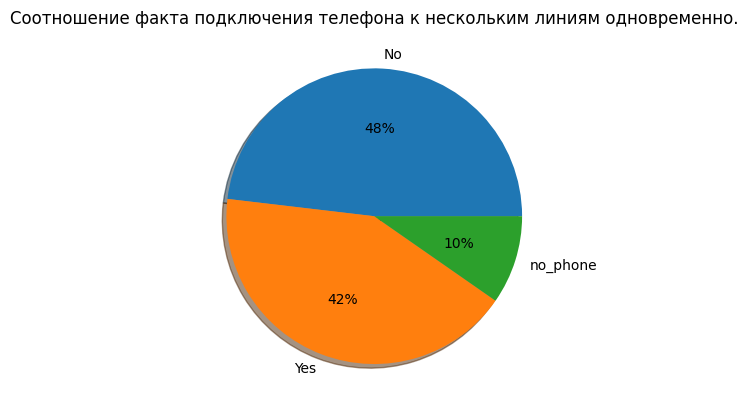

In [110]:
pivot_lines, pie_lines = pivot_pie(df, 'multiple_lines','begin_date','count',
                          'Соотношение факта подключения телефона к нескольким линиям одновременно.')

In [111]:
pivot_lines

,begin_date
multiple_lines,
No,3390
Yes,2971
no_phone,682


Телефоны практически половины клиентов не имеют подключения к нескольким линиям одновременно, 10% от общего числа абонентов не имеют телефона.

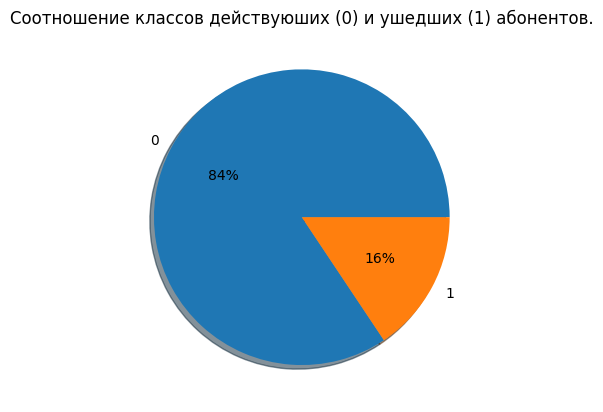

In [112]:
pivot_left, pie_left = pivot_pie(df, 'target','begin_date','count',
                          'Соотношение классов действуюших (0) и ушедших (1) абонентов.')

In [113]:
pivot_left

,begin_date
target,
0,5942
1,1101


Мы видим сильный дисбаланс классов - в нашей выборке только 16% абонентов принадлежат к классу "ушедших" клиентов.

Мы готовы составить портрет типичного пользователя услуг связи -

Финансовый профиль: Средние месячные расходы составляют около 70 единиц, суммарные траты около 1345 единиц.
Частота оплаты: Ежемесячная оплата, чаще всего через электронный чек.

Тип подключения: Оптическое волокно.

Использование интернет услуг:

Не использует облачное хранилище и антивирус.

Не имеет выделенной линии технической поддержки.

Может использовать стриминговое ТВ и каталог фильмов.

Социальный портрет:

Возраст — преимущественно работоспособное население.

Имеет детей.

Скорее всего состоит в браке.

В равной степени может быть мужчиной или женщиной.

Телефонные услуги: Не подключен к нескольким линиям одновременно.

Из этого следует, что типичный абонент — это человек среднего возраста с семьей и детьми, использующий интернет через оптическое волокно, оплачивающий услуги ежемесячно и не склонный к использованию дополнительных сервисов, таких как облачное хранилище или антивирус.

## Портрет абонента, расторгнувшего договор

In [114]:
def two_hist(column, title):
    plt.hist(df[df['target'] == 0][column], bins=10, alpha=0.5, label='Действующие абоненты', density = True)
    plt.hist(df[df['target'] == 1][column], bins=10, alpha=0.5, label='Ушедшие абоненты', density = True)
    plt.legend(loc='upper right')
    plt.title(title)
    plt.ylabel('Доля')
    plt.show()

In [115]:
def two_box(column):
    fig, axes = plt.subplots(1, 2)
    sns.boxplot(x=column ,data=df[df['target'] == 0], palette="Blues",ax=axes[0]).set_title('Действующие абоненты')
    sns.boxplot(x=column, data=df[df['target'] == 1], palette="Blues",ax=axes[1]).set_title('Ушедшие абоненты')
    fig.tight_layout()
    return plt.show()

In [116]:
def left_stay_graph(column):
    sns.histplot(
        df,
        y=column,
        hue='target',
        multiple='fill',
    )
    plt.title(f'Доля расторгнувших по "{column}"')
    plt.xlabel('Доля');

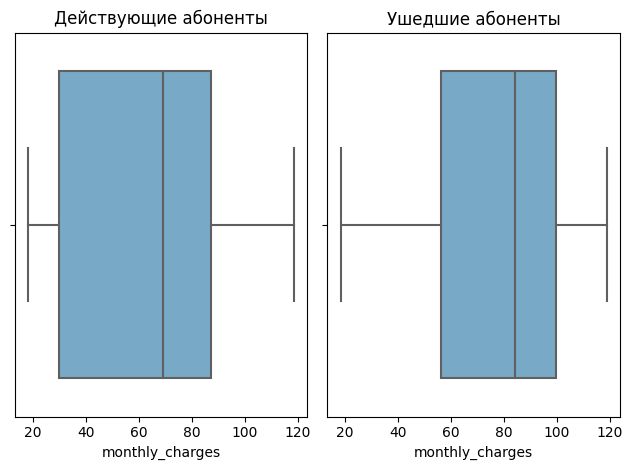

In [117]:
two_box('monthly_charges')

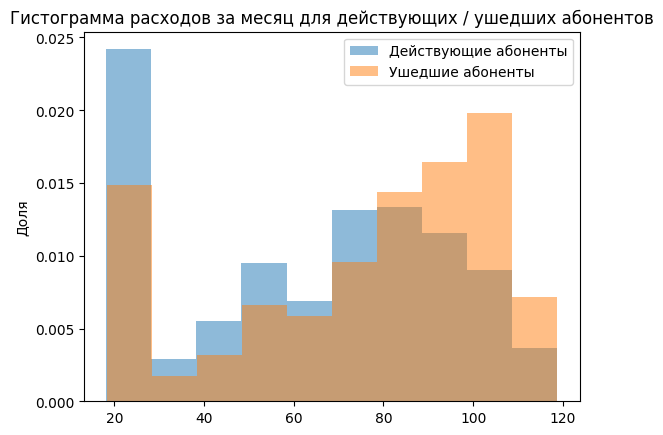

In [118]:
two_hist('monthly_charges','Гистограмма расходов за месяц для действующих / ушедших абонентов')

Диаграмма для ежемесячных платежей действующих и ушедших абонентов нагладно показывает, что ушедшие абоненты в среднем платили больше, чем оставшиеся. Медиана их расходов выше. Видно бОльшее количество абонентов с высокими ежемесячными расходами среди ушедших, что может говорить о возможной причине оттока (высокая стоимость услуг).

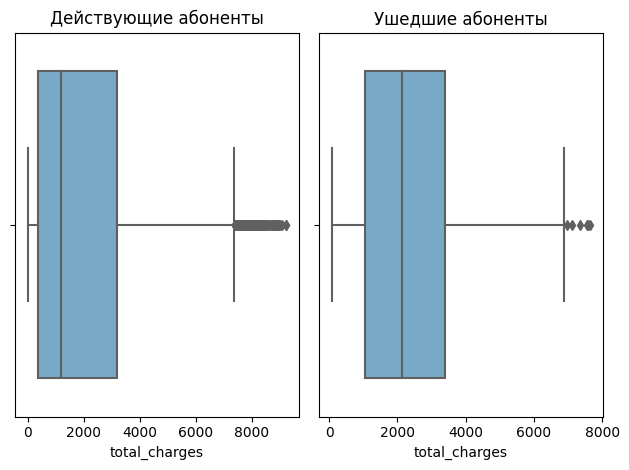

In [119]:
two_box('total_charges')

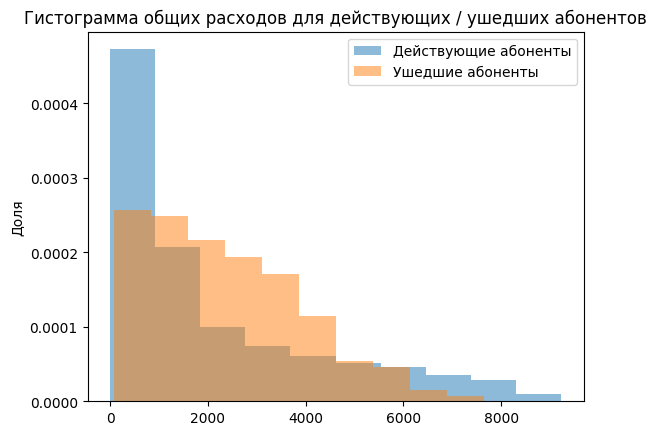

In [120]:
two_hist('total_charges','Гистограмма общих расходов для действующих / ушедших абонентов')

Общие расходы ушедших абонентов  сосредоточены в диапазоне 0–4000. Однако распределение чуть более равномерное, и медиана выше по сравнению с действующими абонентами. Это говорит о том, что ушедшие абоненты, как правило, тратили больше за весь срок обслуживания. Распределение общих расходов для действующих абонентов резко убывает, начиная с низких значений, что указывает на большую долю недавно подключившихся клиентов. У ушедших абонентов распределение более равномерное и указывает на тенденцию ухода абонентов как с небольшими, так и с высокими общими расходами.

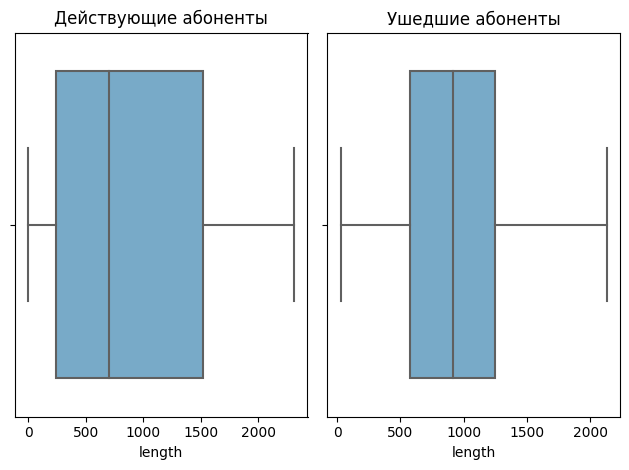

In [121]:
two_box('length')

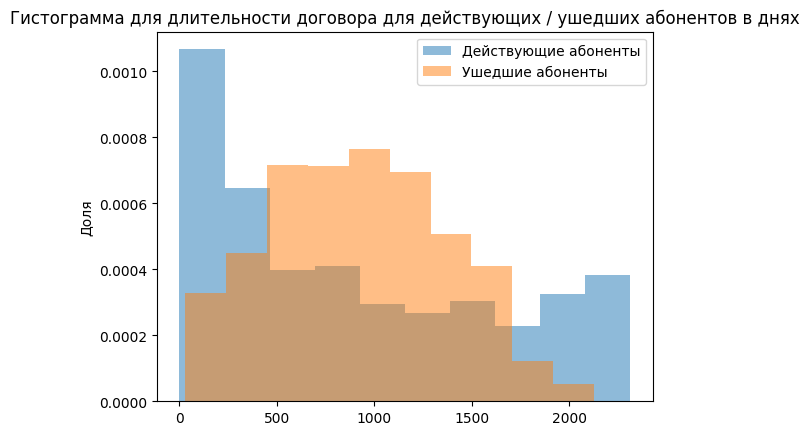

In [122]:
two_hist('length','Гистограмма для длительности договора для действующих / ушедших абонентов в днях')

Действующие абоненты в целом демонстрируют более равномерное распределение по длительности договора. Мы видим, что чаще всего клиенты расторгали договор, пользуясь услугами связи 500 - 1400 дней (от 1.3 года до 3.8 лет).

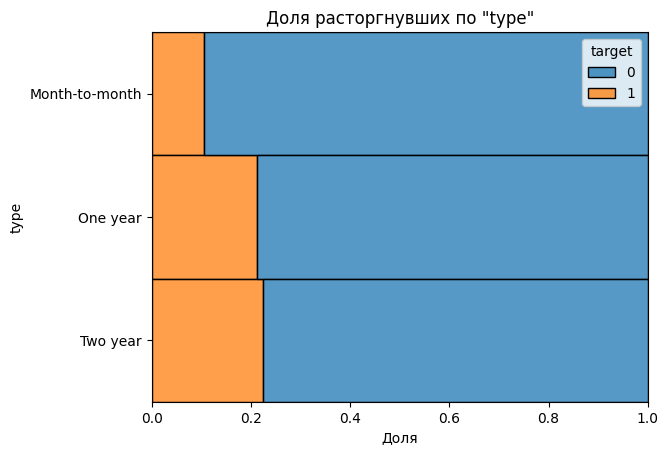

In [123]:
left_stay_graph('type')

Ушедшие клиенты намного чаще оплачивали услуги раз в один / два года.

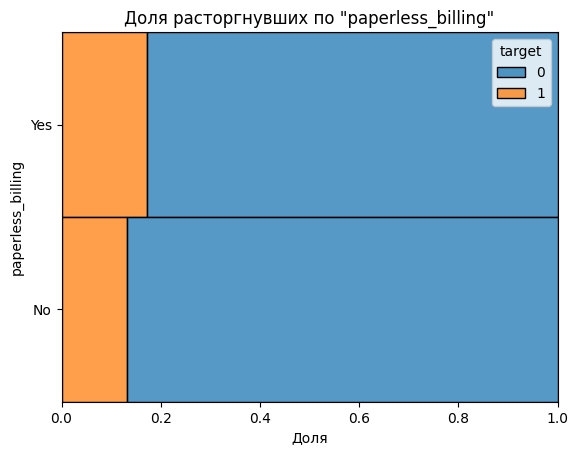

In [124]:
left_stay_graph('paperless_billing')

Ушедшие клиенты чаще получали расчетный лист электронно.

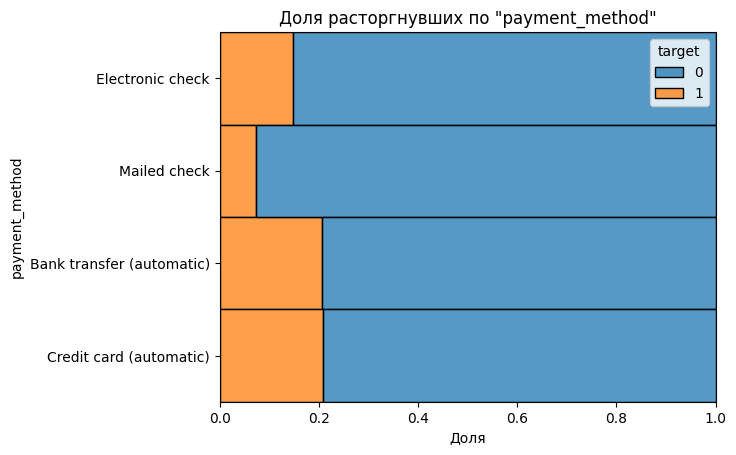

In [125]:
left_stay_graph('payment_method')

Абоненты, которые расторгли договор, чаще всего оплачивали услуги электронно - через банковские транкзакции или автоплатежом.

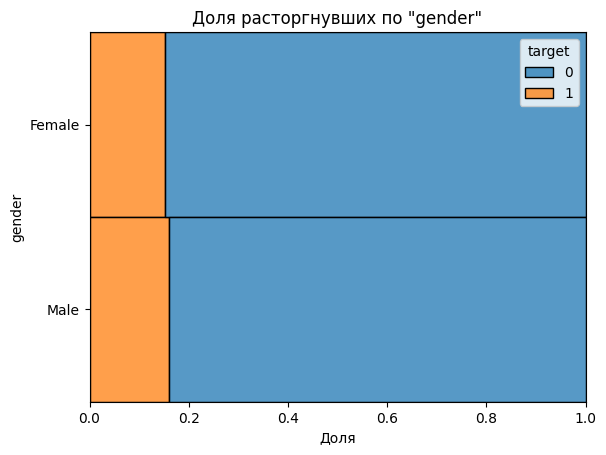

In [126]:
left_stay_graph('gender')

Мы не видим связи между полом и фактом ухода клиента.

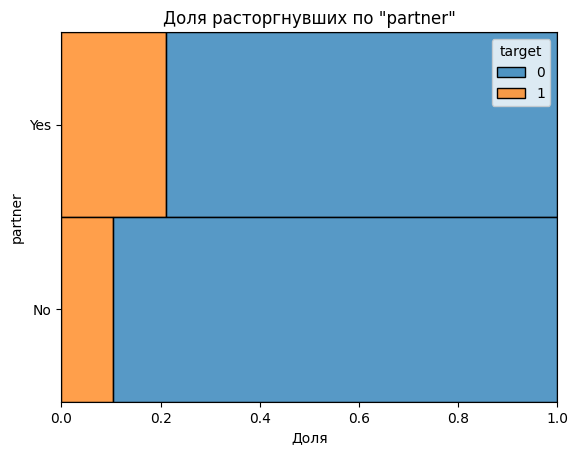

In [127]:
left_stay_graph('partner')

Большая часть ушедших абонентов находились в браке.

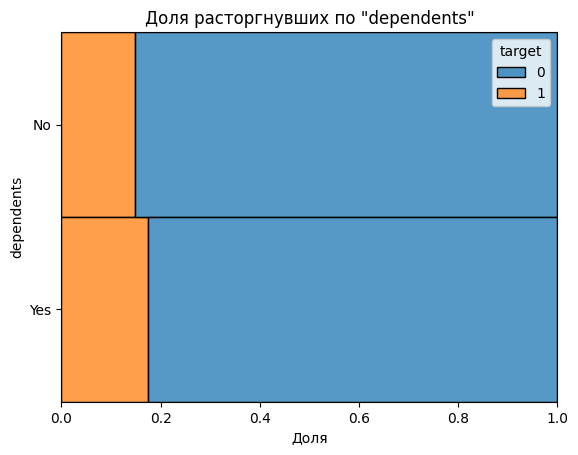

In [128]:
left_stay_graph('dependents')

А также у бОльшей части ушедших клиентов есть дети.

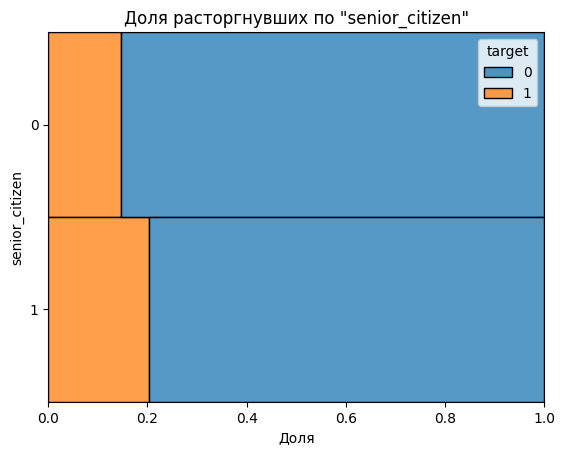

In [129]:
left_stay_graph('senior_citizen')

Заметно, что среди пенсионеров бОльшая доля ушедших клиентов.

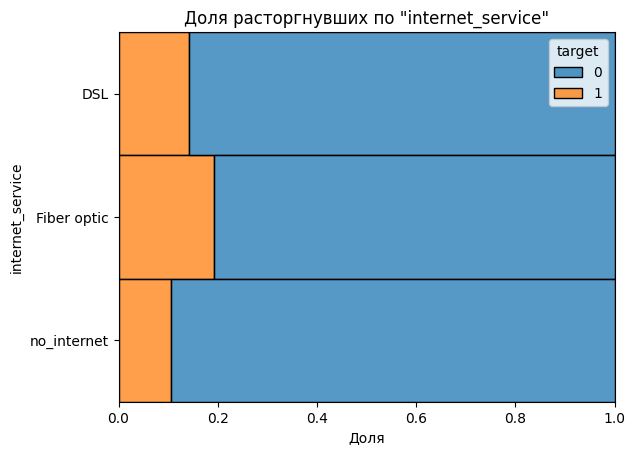

In [130]:
left_stay_graph('internet_service')

Тип подключения ушедшего клиента - оптическое волокно. 

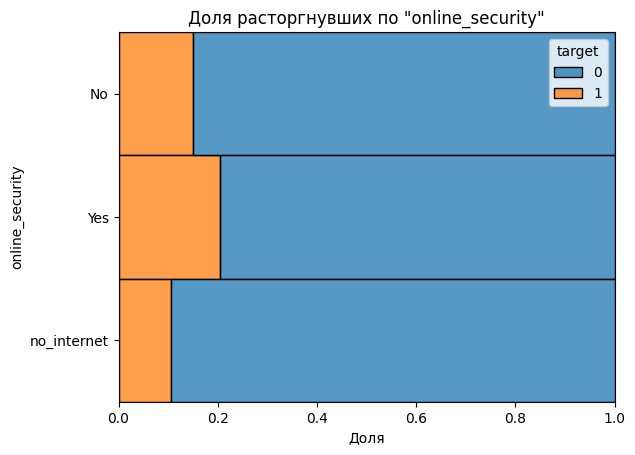

In [131]:
left_stay_graph('online_security')

У ушедшего клиента скорее всего нет функции блокировки опасных сайтов.

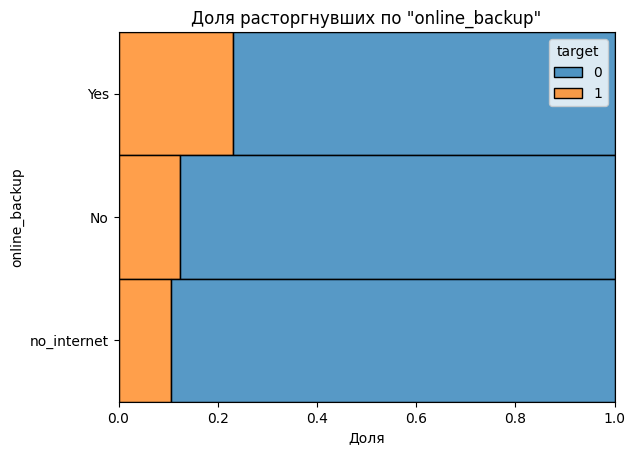

In [132]:
left_stay_graph('online_backup')

Данный график показывает нам связь между наличием облачного хранилища и фактом ухода клиента.

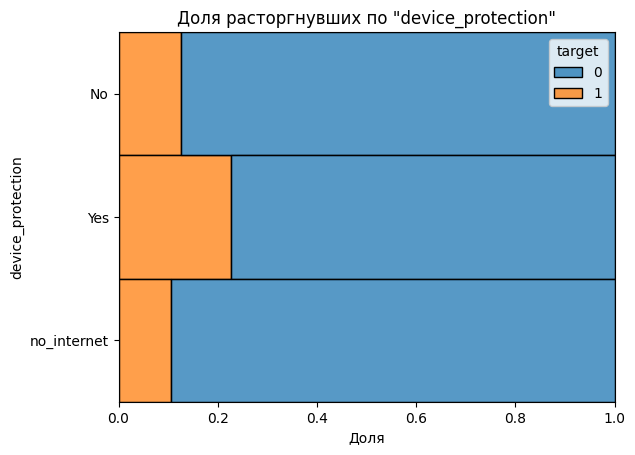

In [133]:
left_stay_graph('device_protection')

У ушедшего клиента, чаще всего, был подключен антивирус. 

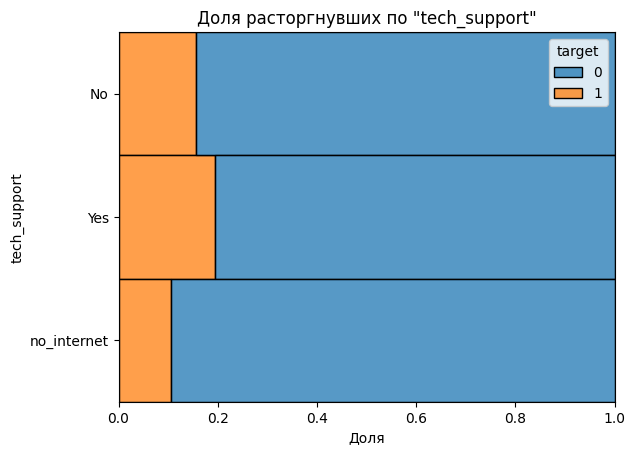

In [134]:
left_stay_graph('tech_support')

Ушедший клиент скорее имел выделенную линию технической поддержки, но разница с действующими клиентами не велика.

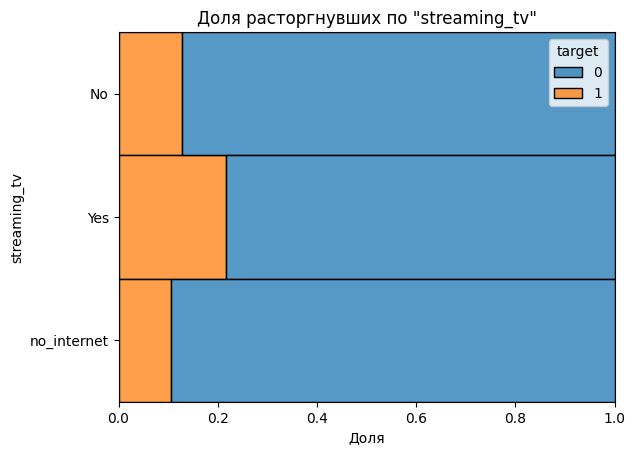

In [135]:
left_stay_graph('streaming_tv')

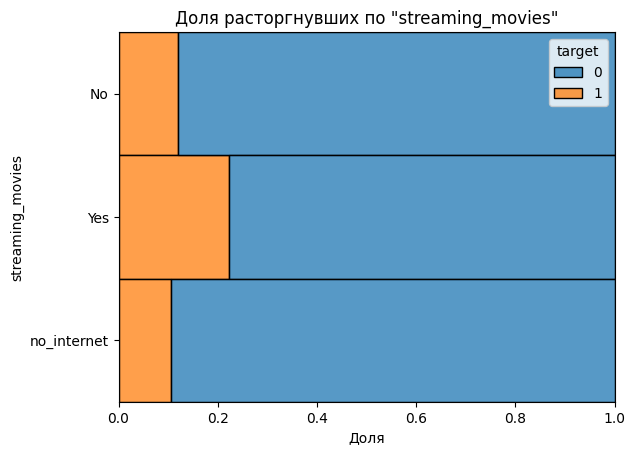

In [136]:
left_stay_graph('streaming_movies')

У клиента, который собирается расторгнуть договор, скорее всего, есть доступ к стримингому телевидению и каталогу фильмов.

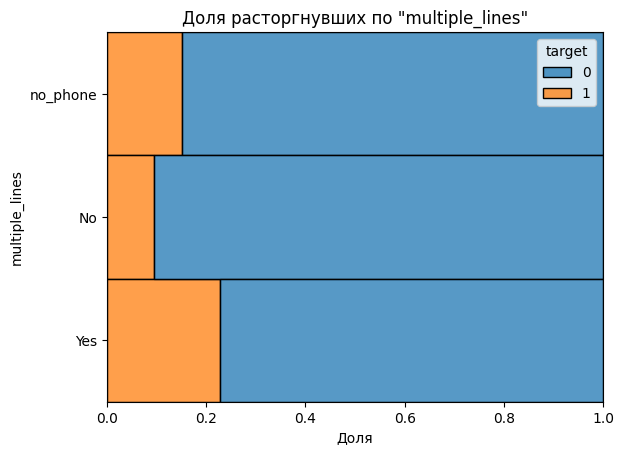

In [137]:
left_stay_graph('multiple_lines')

Мы видим небольшое влияние факта подключения телефона к нескольким линиям одновременно на вероятность оттока клиента.

Мы готовы составить портрет среднестатического клиента, который может расторгнуть договор.

Финансовые аспекты:
- Ушедшие клиенты в среднем платили больше за услуги по сравнению с оставшимися.
- Их медианные ежемесячные расходы выше, а среди них больше пользователей с высокими затратами, что может свидетельствовать о влиянии стоимости услуг на отток.
- Общие расходы ушедших абонентов распределены более равномерно и имеют более высокую медиану, что говорит о значительных затратах на протяжении всего срока обслуживания.

Длительность пользования услугами:
- Ушедшие абоненты имеют более нормальное и равномерное распределние на гистограмме длительности договора.
- Они чаще выбирали оплату раз в один или два года, а не ежемесячные платежи.
- Ушедшие клиенты предпочитали получать расчетный лист электронно, что говорит о склонности к цифровым каналам взаимодействия.
- Основные способы оплаты — банковские транзакции и автоплатежи.

Социально-демографические факторы:
- Ушедшие абоненты чаще состояли в браке и имели детей, что может указывать на дополнительные финансовые обязательства и более требовательный подход к выбору услуг.
- Среди пенсионеров наблюдается высокая доля оттока, что может быть связано с особыми потребностями и ограниченным бюджетом.
- Пол не оказывает влияния на вероятность оттока.

Тип подключения и услуги:
- Основной тип подключения ушедших клиентов — оптическое волокно.
- Ушедшие клиенты реже пользовались функцией блокировки опасных сайтов.
- Они чаще имели подключенные дополнительные сервисы, такие как антивирус, выделенная линия поддержки, доступ к стриминговым сервисам и каталогу фильмов.

Технические особенности:
- Подключение нескольких телефонных линий оказывает небольшое влияние на вероятность оттока, однако такие клиенты чаще расторгают договоры.

Ушедший клиент — это, скорее всего, семейный пользователь среднего или пенсионного возраста, имеющий оптическое подключение, предпочитающий цифровые способы взаимодействия и оплаты. Он использует широкий спектр услуг, но сталкивается с высокой стоимостью, что является одной из ключевых причин оттока. Основной риск для компании — клиенты с высокими ежемесячными расходами, которые чувствительны к цене и могут искать более выгодные предложения на рынке.

## Корреляционный анализ

In [ ]:
phik_overview = df.phik_matrix(interval_cols = ['length', 'monthly_charges','total_charges'])
plot_correlation_matrix(phik_overview.values, x_labels=
                        phik_overview.columns, y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map='PiYG', title=r'correlation $\phi_K$', fontsize_factor=1,
                        figsize=(18,15))
plt.tight_layout()

Анализируя корреляцию целевого признака с входными, можем сделать несколько выводов.

Существует умеренная положительная корреляция между target и length: клиенты с большей длительностью договора чаще попадают в группу ушедших клиентов. Это говорит о том, что долгосрочные клиенты могут быть склонны к оттоку, что может быть связано с накопившимся недовольством или изменением рыночной ситуации.

Умеренная положительная корреляция между begin date и target: клиенты, которые начали пользоваться услугой в более поздние годы (например, недавние клиенты), чаще расторгают договор. Это может отражать изменяющиеся рыночные условия, растущую конкуренцию или недостаточную лояльность новых клиентов.

Слабая положительная корреляция c multiple_lines (0.11) - наличие нескольких телефонных линий связано с незначительным повышением вероятности оттока.

Очень слабая положительная корреляция с streaming_tv (0.08) и streaming_tv (0.09) - наличие подписок на стриминг фильмов и ТВ практически не влияет на отток.

Умеренная положительная корреляция с partner (0.23): наличие партнера повышает  вероятность оттока.

Слабая положительная корреляция с senior_citizen (0.09): пожилые клиенты немного более склонны к оттоку.

Практически отсутствует корреляция c полом (0.01) : пол клиента не влияет на вероятность оттока.

Умеренная положительная корреляция c total_charges (0.30): клиенты с более высокими общими расходами имеют повышенную вероятность расторжения договора.

Слабая положительная корреляция c monthly_charges (0.21): клиенты с высокими ежемесячными расходами чаще уходят. Это логично, так как высокие расходы могут вызывать недовольство.

Слабая положительная корреляция с payment_method (0.21): способ оплаты влияет на отток, но незначительно.

Слабая положительная корреляция paperless_billing (0.08): клиенты, использующие электронные счета, немного чаще расторгают договор.


Мы наблюдаем мультиколлинеарные входные признаки - признаки, связанные с интернет-услугами (streaming_movies, streaming_tv, tech_support, device_protection, online_backup, online_security), имеют очень высокую корреляцию между собой (коэффициенты больше 0.9). Скорее всего это связано с тем, что эти услуги часто предлагаются в пакете.
Мультиколлинеарность видна между признаками total_charges и monthly_charges (корреляция ~ 0.86), и length и begin_date (корреляция ~ 0.98).

In [ ]:
def scatter(x, y, hue,title):
    sns.scatterplot(x = df[x], y = df[y], hue = df[hue]).set_title(title);

In [ ]:
scatter('length','monthly_charges','target',
        'Диаграмма рассеяния для длительности договора и ежемесячных расходах абонента c изображением факта ухода')

Мы видим, что ушедшие клиенты равномерно распределены в значении длительности договора от 500 до 1500.

In [141]:
scatter('monthly_charges','total_charges','target',
        'Диаграмма рассеяния ежемесячных расходах и общих расходах абонента c изображением факта ухода')

Существует линейная зависимость между ежемесячными и общими расходами, что логично, так как общие расходы зависят от суммы ежемесячных и длительности договора.
Ушедшие клиенты часто сосредоточены на небольших значениях total_charges, что подтверждает, что новые клиенты чаще расторгают договор. Мы видим большое количество ушедших клиентов среди тех, кто ежемесячно платит более 100 единиц.

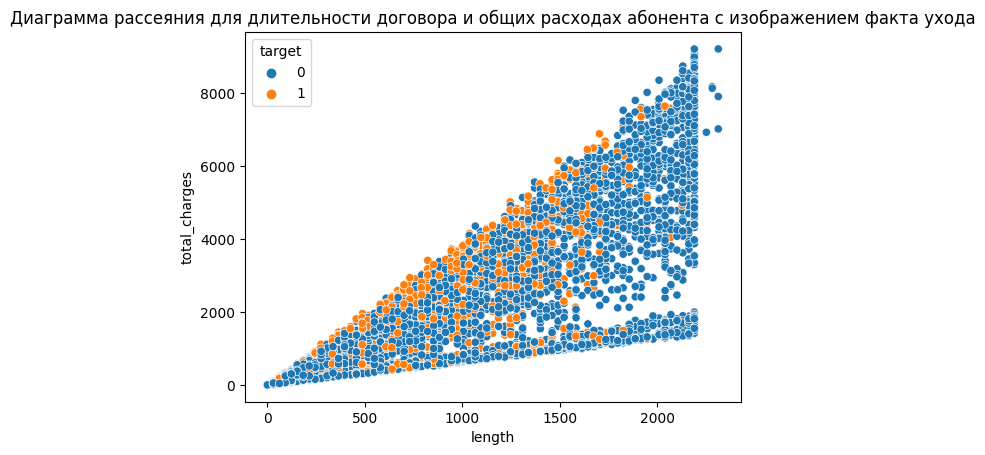

In [142]:
scatter('length','total_charges','target',
        'Диаграмма рассеяния для длительности договора и общих расходах абонента c изображением факта ухода')

Здесь также очевидна сильная линейная зависимость между длительностью контракта и общими расходами.
Ушедшие клиенты в большинстве случаев имеют меньшие значения length и total_charges, что  подчеркивает, что новые клиенты чаще уходят.
Действующие клиенты чаще имеют более длительный срок договора и, как следствие, более высокие общие расходы.

Анализ показал, что основными факторами, связанными с оттоком клиентов, являются высокие ежемесячные расходы, наличие партнера, продолжительность использования услуги и дата подключения. В то же время демографические факторы, такие как пол и возраст, оказывают менее значительное влияние.

Из обучающей выборки будут удалены признаки с датой - begin, end date - а также признак monthly_payment, так как он сильно мультикоррелирует с total_charges. Также будут удалены все признаки описывающие интернет услуги, кроме двух - device protection и streaming_movies, так как все такие сильно мультикоррелируют между собой. Признак с полом абонента также будет удален из-за очень слабой корреляции с таргетом.

In [143]:
df.drop(columns = ['end_date','begin_date','monthly_charges',
                   'internet_service', 'online_security', 'online_backup',
                  'gender','streaming_tv','tech_support'], inplace=True,axis=1)

In [144]:
df.duplicated().sum()

17

In [145]:
df.drop_duplicates(inplace=True)

In [146]:
df.reset_index(drop=True, inplace=True)

## Обучение модели

In [147]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'target',
                                                                  axis=1),
                                                     df['target'],
                                                     test_size = TEST_SIZE,
                                                     random_state = RANDOM_STATE,
                                                     stratify = df['target'])

In [148]:
X_train.duplicated().sum()

0

In [149]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
DummyClassifier(strategy='most_frequent')
preds = dummy_clf.predict(X_test)
roc_auc_dummy = roc_auc_score(y_test, preds)

In [150]:
print(f'ROC AUC dummy - {roc_auc_dummy}')

ROC AUC dummy - 0.5


В дальнейшем мы будем ориентироваться на метрику Dummy модели. Если Roc Auc нашей будущей модели будет равна или меньше этой, то мы будем считать, что модель не выявила закономерности между целевым и входными признаками.

In [151]:
X_train.columns

Index(['type', 'paperless_billing', 'payment_method', 'total_charges',
       'senior_citizen', 'partner', 'dependents', 'device_protection',
       'streaming_movies', 'multiple_lines', 'length'],
      dtype='object')

In [152]:
#количественные признаки 
num_columns = ['total_charges','length']

In [153]:
#категориальные признаки
cat_columns = ['type', 'paperless_billing', 'payment_method', 'senior_citizen', 'partner', 'dependents',
               'device_protection', 'streaming_movies', 'multiple_lines']

In [154]:
#кодируем категориальные признаки с помощью OrdinalEncoder
ord_pipe = Pipeline(
    [
        (
            'simpleimputer_ord',
        SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        ),
        (
            'ord',
        OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = np.nan)),
        (
            'simpleimputer_after_ord',
        SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        )    
    ])


In [155]:
ohe_pipe = Pipeline(
    [
        (
            'simpleimputer_ohe',
        SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        ),
        (    
            'ohe',
        OneHotEncoder(drop='first', sparse_output = False, handle_unknown = 'ignore')
        )
    ])

In [156]:
data_preprocessor = ColumnTransformer(
    [('ord', ord_pipe, cat_columns),
    ('num', [MinMaxScaler(),StandardScaler()], num_columns)],
    remainder = 'passthrough')

In [157]:
data_preprocessor_ohe = ColumnTransformer(
    [('ohe',ohe_pipe,cat_columns),
    ('num', [MinMaxScaler(),StandardScaler()], num_columns)],
    remainder = 'passthrough')

In [158]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state = RANDOM_STATE))
    ]
)

In [159]:
    parameters_distributions = [
        {
            'models': [DecisionTreeClassifier(random_state = RANDOM_STATE,class_weight='balanced')],
            'models__max_depth': range(2, 60),
            'models__min_samples_leaf': range(2,20),
            'preprocessor': [data_preprocessor],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
        },
        {
            'models': [LogisticRegression(random_state = RANDOM_STATE, solver='saga', penalty='l1',
                                          class_weight='balanced')],
            'models__C': range(1,9),
            'preprocessor': [data_preprocessor_ohe],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        },
        {
            'models': [SVC(random_state = RANDOM_STATE, probability = True)],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
            'preprocessor': [data_preprocessor]
        },
        {
            'models': [KNeighborsClassifier()],
            'models__n_neighbors': range(1, 40),
            'preprocessor': [data_preprocessor],
            'preprocessor__num': [StandardScaler(), MinMaxScaler()]
        },
        {
            'models': [RandomForestClassifier(random_state = RANDOM_STATE,class_weight='balanced')],
            'models__max_depth': range(2, 100),
            'models__min_samples_leaf': range(2,50),
            'models__min_samples_split':range(2,20),
            'preprocessor': [data_preprocessor],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
        },
        {   'models': [GradientBoostingClassifier(random_state = RANDOM_STATE,
                                                   loss='log_loss')],
            'models__n_estimators': [100,200,300,400,500],
            'models__min_samples_leaf': range(2,13),
            'models__max_depth': range(30,200),
            'models__learning_rate':[0.1,0.4,0.7,1],
             'preprocessor': [data_preprocessor],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
        },
        {
            'models': [HistGradientBoostingClassifier(random_state = RANDOM_STATE)],
            'models__max_iter': range(100, 1000),
            'models__max_depth': range(0, 200),
            'models__l2_regularization':[0.2,0.4,0.6],
            'models__min_samples_leaf': range(20,70),
            'preprocessor': [data_preprocessor],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
        },
        {   'models': [lgb.LGBMClassifier(random_state = RANDOM_STATE,class_weight='balanced',force_row_wise=True)],
            'models__max_depth': range(0, 50),
            'models__num_leaves': range(2,13),
            'preprocessor': [data_preprocessor],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
        }
    ]

Для поиска лучшей модели используются восемь моделей классификации - дерево решений,случайный лес, логистическая регрессия (обязательно с регуляризацией из-за мультиколлинеарности), SVC, kNN, Gradient Boosting,Hist Gradient Boosting, LGMBClassifier с разными гиперпараметрами. Дерево решений, случайный лес, LGMB Classifier выполняются с балансировкой классов.

In [160]:
randomized_search = RandomizedSearchCV(
    pipe_final, parameters_distributions, cv=5, scoring = 'roc_auc',
    random_state = RANDOM_STATE, n_jobs = 1,n_iter = 50)

In [161]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ord',
                                                                               Pipeline(steps=[('simpleimputer_ord',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=nan)),
                                                                                               ('simpleimputer_after_ord',
                                                                                                SimpleImputer(strategy='most_frequent')...
                                                                                                           ('simpleimputer_after_ord',
                                                                                                            SimpleImputer(strategy='most_frequent'))]),
                                                                                           ['type',
                                                                                            'paperless_billing',
                                                                                            'payment_method',
                                                                                            'senior_citizen',
                                                                                            'partner',
                                                                                            'dependents',
                                                                                            'device_protection',
                                                                                            'streaming_movies',
                                                                                            'multiple_lines']),
                                                                                          ('num',
                                                                                           'passthrough',
                                                                                           ['total_charges',
                                                                                            'length'])])],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=200125, scoring='roc_auc')

In [162]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleimputer_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleimputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['type', 'paperless_billing',
                                         

In [163]:
print('Метрика ROC-AUC, полученная с помощью кросс-валидации:\n\n', randomized_search.best_score_)

Метрика ROC-AUC, полученная с помощью кросс-валидации:

 0.908775884287221


Все десять лучших моделей - HistGradientBoostingClassifier с разными гиперпараметрами

In [164]:
res = (
    pd.DataFrame({
        "mean_test_score": randomized_search.cv_results_["mean_test_score"],
        "mean_fit_time": randomized_search.cv_results_["mean_fit_time"]})
      .join(pd.json_normalize(randomized_search.cv_results_["params"]).add_prefix("param_"))
)

res['param_models'] = res['param_models'].apply(lambda x: x.__class__.__name__)

res_grouped = res.groupby('param_models').agg(
    mean_test_score=('mean_test_score', 'max'),
    mean_fit_time=('mean_fit_time', 'mean')
).reset_index()

res_grouped = res_grouped.sort_values(by='mean_test_score', ascending=False)

print(res_grouped)

                     param_models  mean_test_score  mean_fit_time
0  HistGradientBoostingClassifier         0.908776       1.567616


In [165]:
randomized_search.cv_results_['params']

[{'preprocessor__num': 'passthrough',
  'preprocessor': ColumnTransformer(remainder='passthrough',
                    transformers=[('ord',
                                   Pipeline(steps=[('simpleimputer_ord',
                                                    SimpleImputer(strategy='most_frequent')),
                                                   ('ord',
                                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                   unknown_value=nan)),
                                                   ('simpleimputer_after_ord',
                                                    SimpleImputer(strategy='most_frequent'))]),
                                   ['type', 'paperless_billing', 'payment_method',
                                    'senior_citizen', 'partner', 'dependents',
                                    'device_protection', 'streaming_movies',
                            

Создадим нейронную сеть.

In [166]:
preprocessor_net = ColumnTransformer(
            transformers=[
                ("numeric", StandardScaler(), num_columns),
                ("category", OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first'), cat_columns) #добавила drop 'first'
            ]
)

In [171]:
train = preprocessor_net.fit_transform(X_train)
test = preprocessor_net.transform(X_test)

In [172]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [173]:
for i, (train_index, valid_index) in enumerate(kf.split(train)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={valid_index}")

Fold 0:
  Train: index=[   0    1    2 ... 5266 5267 5268]
  Test:  index=[   7    8    9 ... 5252 5255 5265]
Fold 1:
  Train: index=[   0    1    2 ... 5266 5267 5268]
  Test:  index=[  14   15   17 ... 5239 5256 5264]
Fold 2:
  Train: index=[   1    3    4 ... 5265 5266 5268]
  Test:  index=[   0    2    5 ... 5261 5263 5267]
Fold 3:
  Train: index=[   0    2    4 ... 5266 5267 5268]
  Test:  index=[   1    3   12 ... 5250 5251 5258]
Fold 4:
  Train: index=[   0    1    2 ... 5264 5265 5267]
  Test:  index=[   4    6   13 ... 5262 5266 5268]


In [174]:
X_train_net = torch.FloatTensor(train[train_index])
X_valid_net = torch.FloatTensor(train[valid_index])
X_test_net = torch.FloatTensor(test)
y_test_net = torch.FloatTensor(y_test.values)
y_train_net = torch.FloatTensor(y_train.values[train_index])
y_valid_net = torch.FloatTensor(y_train.values[valid_index])

In [175]:
torch.manual_seed(1234)

In [176]:
n_in_neurons = X_train_net.shape[1]
n_hidden_neurons = 16
n_hidden_neurons_2 = 8
n_hidden_neurons_1 = 4
n_out_neurons = 1

In [177]:
net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_out_neurons)
)

In [178]:
batch_size = 100

num_epochs = 3000
loss = nn.BCEWithLogitsLoss()
num_batches = ceil(len(X_train_net)/batch_size)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [179]:
scores = [] 
for i, (train_index, valid_index) in enumerate(kf.split(train)):
    X_train_net = torch.FloatTensor(train[train_index])
    X_valid_net = torch.FloatTensor(train[valid_index])
    y_train_net = torch.FloatTensor(y_train.values[train_index])
    y_valid_net = torch.FloatTensor(y_train.values[valid_index])
    net = nn.Sequential(
        nn.Linear(n_in_neurons, n_hidden_neurons),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons, n_hidden_neurons_2),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons_2, n_hidden_neurons_1),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons_1, n_out_neurons)
)
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    for epoch in range(num_epochs):
        order = np.random.permutation(len(X_train_net))
        for batch_i in range(num_batches):
            start_index = batch_i * batch_size
            optimizer.zero_grad()
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train_net[batch_indexes]
            y_batch = y_train_net[batch_indexes]
            
            net.train()
            
            preds = net.forward(X_batch).flatten()
            y_batch = y_batch.flatten()
            
            loss_value = loss(preds, y_batch)
            #print(loss_value)
            loss_value.backward()
            optimizer.step() 
            
            if epoch % 300 == 0 or epoch == num_epochs - 1:
                net.eval()
                with torch.no_grad():
                    test_preds_prob = net.forward(X_valid_net).flatten().detach().numpy()
                    roc_auc = roc_auc_score(y_valid_net.numpy(), test_preds_prob)
                    #print('Epoch num',epoch, 'ROC AUC - ',roc_auc)
                    scores.append(roc_auc)
    
final_score = sum(scores)/len(scores) 
print(f'Средняя оценка качества модели на кросс-валидации: {final_score}')

Средняя оценка качества модели на кросс-валидации: 0.7714987609069481


Метрика, полученная с помощью нейронной сети, не показала результаты лучше HistGradientClassifier.

In [180]:
best_model = randomized_search.best_estimator_['models']

In [181]:
print('Лучшая модель - ',best_model)

Лучшая модель -  HistGradientBoostingClassifier(l2_regularization=0.6, max_depth=81,
                               max_iter=325, min_samples_leaf=60,
                               random_state=200125)


In [182]:
X_test_transformed = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test)

In [183]:
preds = best_model.predict(X_test_transformed)
proba_class = best_model.predict_proba(X_test_transformed)

In [184]:
print(f'ROC-AUC на тестовой выборке = ',roc_auc_score(y_test, proba_class[:,1]))

ROC-AUC на тестовой выборке =  0.9036142804563857


In [185]:
print('Accuracy на тестовой выборке:', accuracy_score(y_test, preds)) 

Accuracy на тестовой выборке: 0.9151963574274331


Наша модель показывает отличный результат на тестовой выборке - ROC-AUC на пять пунктов выше требумоего уровня. Точность - практическки 92%, что является хорошим результатом, но нам необходимо проверить какие именно ошибки совершает модель - первого или второго рода - поэтому метрика точности не будет показывать нам полную картину совершаемых моделью ошибок.

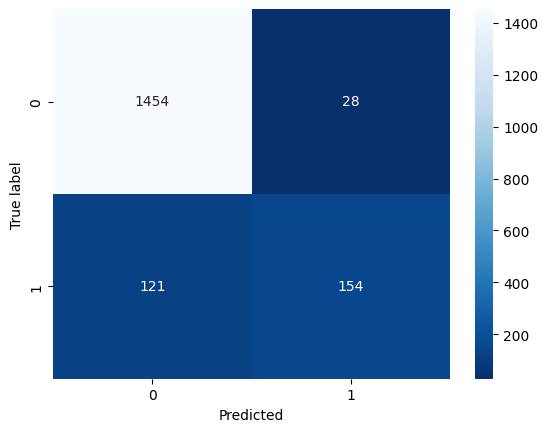

In [186]:
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

Модель правильно классифицировала 1454 клиентов как действующих абонентов, что говорит о высокой точности в определении тех, кто действительно остается.

154 клиент, который действительно расторгнет договор, был правильно идентифицирован моделью. Это положительный результат, так как модель сумела выявить значительную часть ушедших абонентов. 28 клиентов были ошибочно классифицированы как ушедшие, хотя они фактически остались.

Модель не смогла выявить 121 клиентов, которые в действительности расторгли договор, ошибочно классифицировав их как оставшихся. В нашем случае, это будет означать, что данные клиенты не получат промокоды и специальные условия от компании, и, скорее всего, расторгнут договор. Рассмотрим ROC кривую и Precision/Recall Curve и примем решение об изменении порога. Так как в нашем случае важнее выявить абонента, который собирается расторгнуть договор, мы будем опираться на метрику recall.

In [187]:
print('Recall на тестовой выборке:', recall_score(y_test, preds)) 
print('Precision на тестовой выборке:', precision_score(y_test, preds)) 

Recall на тестовой выборке: 0.56
Precision на тестовой выборке: 0.8461538461538461


Мы видим, хороший показатель precision и низкий recall. Это говорит нам о том, что модель имеет низкое количество ложноположительных и большое количество ложноотрицательных ошибок. Это и было показано на матрице ошибок. В нашем случае нам важнее recall - необходимо изменить порог, визуализировав значения precision и recall.

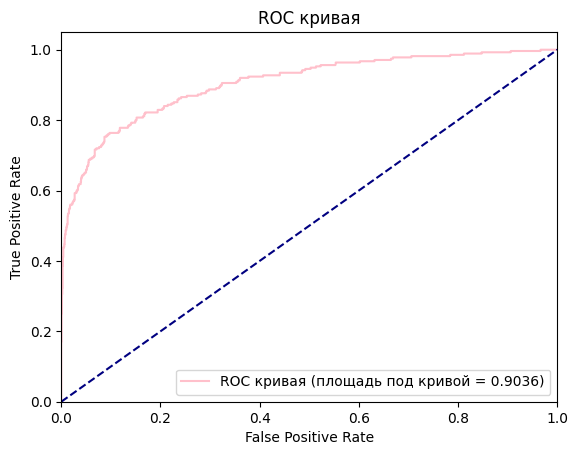

In [188]:
fpr, tpr, treshold = roc_curve(y_test, proba_class[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(
    fpr, 
    tpr, color='pink', 
    label='ROC кривая (площадь под кривой = %0.4f)' % roc_auc
)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc="lower right")
plt.show()

Roc Auc захватывает бОльшую часть прямоугольника и находится сильно выше прямой, мы можем сделать вывод, что наша модель в большинстве случаев правильно предсказывает отток клиента.

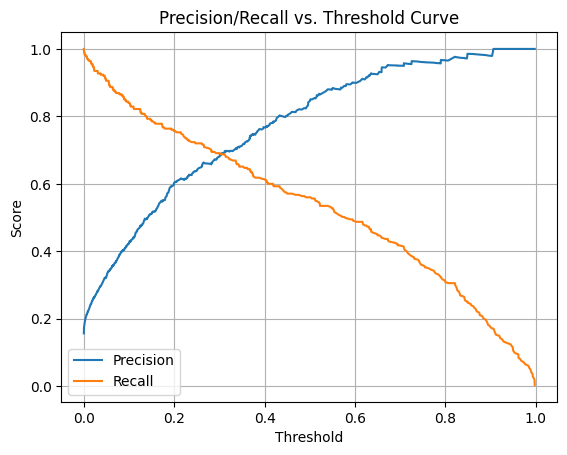

In [189]:
precision, recall, thresholds = precision_recall_curve(y_test, proba_class[:,1])
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision/Recall vs. Threshold Curve')
plt.grid(True)
plt.show()

На графике видно, что при низком пороге (ближе к 0) Precision низкий, так как модель предсказывает много ложных положительных срабатываний. С увеличением порога Precision увеличивается, достигая почти 1 при высоких значениях порога (ближе к 1).
На графике видно, что Recall максимально высок при низких значениях порога, так как модель стремится захватить максимальное количество положительных примеров. Однако с увеличением порога Recall постепенно падает.

Было принято решение изменить порог до 0.1,так как в нашей задаче важно минимизировать пропуск абонентов, которые могут расторгнуть договор. Высокий Recall обеспечит, что почти все такие абоненты будут идентифицированы, даже если некоторые из них будут ложноположительными.

На графике видно, что при пороге 0.1 Recall все еще остается высоким (около 0.8-0.9), что соответствует нашей цели. Precision при этом ниже, но ложноположительные прогнозы не так критичны, как пропуск абонентов, которые собираются расторгнуть договор.

В условиях, где важно предотвратить расторжение договоров, высокий recall позволяет вовремя выявить клиентов,  подверженных риску ухода, чтобы принять меры. Потеря у precision в нашем случае допустима, так как издержки на предложение промокодов / специальных услуг клиентам, которые не собираются уходить, скорее всего ниже, чем потери от ухода клиентов.

In [190]:
threshold = 0.05

In [191]:
pred_new_threshold = (proba_class >= threshold).astype(int)

In [192]:
print(f'Recall на тестовой выборке = ',recall_score(y_test, pred_new_threshold[:,1]))

Recall на тестовой выборке =  0.9054545454545454


C таким recall модель вряд ли пропустит клиента, который собирается расторгнуть договор.

## Анализ важности признаков

In [193]:
preprocessed_ord_names = randomized_search.best_estimator_.named_steps['preprocessor'].transformers_[0][2]

In [194]:
preprocessed_num_names = randomized_search.best_estimator_.named_steps['preprocessor'].transformers_[1][2]

In [195]:
all_preprocessed_cols = preprocessed_ord_names + preprocessed_num_names

In [196]:
X_train_transformed = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed, columns = all_preprocessed_cols)

In [197]:
X_train_transformed.head(5)

,type,paperless_billing,payment_method,senior_citizen,partner,dependents,device_protection,streaming_movies,multiple_lines,total_charges,length
0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,2867.199951,975.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2808.050049,1676.0
2,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,4905.149902,1614.0
3,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,1523.969971,1248.0
4,2.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,1.0,1673.250000,2102.0


In [198]:
X_test_transformed = pd.DataFrame(X_test_transformed, columns = all_preprocessed_cols)

In [199]:
X_test_transformed.head(5)

,type,paperless_billing,payment_method,senior_citizen,partner,dependents,device_protection,streaming_movies,multiple_lines,total_charges,length
0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,612.250000,215.0
1,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,357.500000,306.0
2,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1285.680054,1461.0
3,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,240.910004,92.0
4,1.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,4768.500000,1553.0


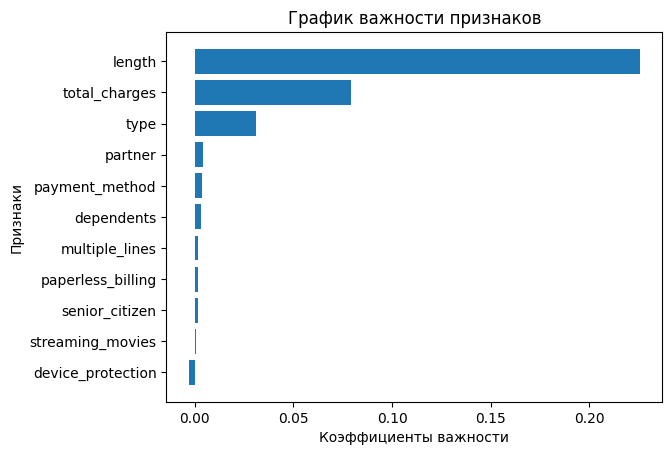

In [200]:
perm_importance = permutation_importance(randomized_search.best_estimator_.named_steps['models'],
                                         X_test_transformed, y_test)

feature_names = X_train_transformed.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel('Коэффициенты важности')
plt.ylabel('Признаки')
plt.title('График важности признаков');

Анализ показал, что наибольшее влияние на вероятность оттока клиента оказывает длительность договора (length). Это означает, что чем дольше клиент пользуется услугами, тем выше вероятность его ухода. Данный фактор может свидетельствовать о накоплении недовольства или об изменении потребностей клиента со временем.

На втором месте по значимости находится общая сумма расходов (total_charges). Клиенты с высокими совокупными затратами за весь период обслуживания чаще принимают решение о расторжении договора, что может быть связано с высокой стоимостью услуг и стремлением снизить расходы.

Третьим по значимости фактором является тип оплаты (type).

Все остальные факторы (payment_method, multiple_lines, partner, streaming_movies, senior_citizen, paperless_billing, device_protection, dependents) оказались наименее значимыми факторами для модели.


Ключевыми факторами оттока являются длительность договора, общая сумма расходов и тип оплаты. Длительные обязательства и высокие расходы могут негативно сказываться на удержании клиентов, в то время как подключенные дополнительные услуги и демографические характеристики играют менее значимую роль.

## Для одного из важных входных признаков проведите дополнительное исследование: 
Покажите график зависимости входного и целевого признаков.

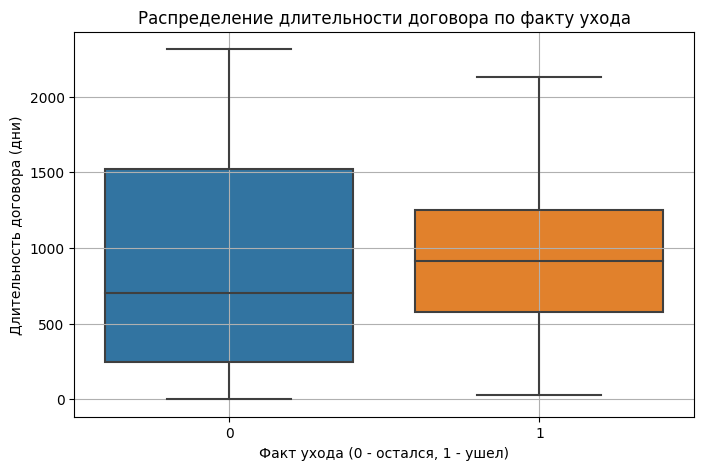

In [201]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='target', y='length')
plt.title('Распределение длительности договора по факту ухода')
plt.xlabel('Факт ухода (0 - остался, 1 - ушел)')
plt.ylabel('Длительность договора (дни)')
plt.grid()
plt.show()

На графике представлены распределения длительности договора в днях для двух категорий абонентов.
 1. Действующие абоненты:
 
 Распределение шире, включая значительную долю абонентов с продолжительностью договора более 1000 дней.
 
 Верхние и нижние границы  показывают больший разброс, чем у ушедших.
 
 Медиана ниже, чем у ушедших клиентов.
 
 
 2. Ушедшие абоненты :

 Ушедшие клиенты имеют большую медианную длительность договора, что подтверждает может говорить о
 недовольстве или усталости от услуг компании.
 
Оператору связи стоит обратить внимание на клиентов с длительным сроком использования услуг, так как именно они чаще расторгают договор.

Благодаря проведенному исследованию мы создали модель, которая может эффективно предсказывать клиентов, планирующих отказаться от услуг оператора связи "ТелеДом".

Перед началом исследования мы загрузили и прочитали все необходимые датасеты. Мы проверили наши данные на наличие пропусков, аномалий, дубликатов и обработали их при необходимости. Далее мы объединили все наши таблицы в одну и создали целевой признак - факт оттока клиента - который принимает бинарное значение (1, если клиент расторгнул договор, 0 - если нет). Далее мы создали новый входной признак - длительность договора (в днях) на основе даты создания и расторжения договора (у действующих абонентов дата выгрузки датасета была указана как дата расторжения договора). Далее мы провели исследовательский анализ данных.

Благодаря исследовательскому анализу данных мы составили портрет типичного абонента оператора связи, и портрет ушедшего абонента. Типичный клиент — это человек среднего возраста, с семьей и детьми, использующий интернет через оптоволокно, предпочитающий ежемесячную оплату и ограничивающий использование дополнительных сервисов.Ушедший клиент — это семейный пользователь среднего или пенсионного возраста, использующий комплексные услуги, но чувствительный к стоимости. Основной риск — высокая цена.

Корреляционный анализ выявил, что наиболее значимыми факторами, связанными с оттоком клиентов, являются длительность договора: клиенты с более продолжительным сроком обслуживания склонны к расторжению, ежемесячные расходы более высокие затраты увеличивают вероятность оттока. При этом демографические характеристики, такие как пол и возраст, оказывают незначительное влияние на отток. Обнаружена сильная мультиколлинеарность среди некоторых признаков (например, между total_charges и monthly_charges, length и begin date, а также между всеми признаками, связанные с дополнительными интернет услагми), что потребовало удаления лишних признаков для избежания избыточности данных.

Мы разделили наш датасет на тренировочную и тестовую выборку, закодировали категориальные и количественные признаки и с помощью пайплайна нашли лучшую модель для нашей задачи. Ей оказалась HistGradientClassifier с ROC AUC равной 91%. Мы использовали данную модель для предсказания на тестовой выборке, где наша метрика увеличилась на один пункт. Мы построили матрицу ошибок, ROC кривую и Precision/Recall vs Threshold Curve и пришли к нескольким выводам. Модель успешно классифицировала 1449 действующих абонентов, и 152 абонентов, которые действительно расторгнет договор. Модель ошибочно определила 28 клиента как ушедших, хотя они остались, и 121 клиентов, которые фактически расторгнут договор, были ошибочно определены как оставшиеся. Наша модель показала недостаточно высокий recall, поэтому было принято решение, исходя из графика recall/precision изменить порог для повышения recall, так как для компании важнее предотвратить отток, чем избежать ложноположительных значений. Высокий recall позволяет идентифицировать практически всех потенциальных ушедших клиентов, что дает возможность вовремя принять меры по их удержанию.

После изменения порога мы создали график анализа входных признаков, который показал, что главным фактором, влияющим на отток клиентов является длительность договора. Чем дольше клиент пользуется услугами, тем выше вероятность расторжения договора. Также на целевой признак сильно влияет общая сумма расходов, что связано с высокой стоимостью услуг. Тип оплаты (type) также оказывает значительное влияние. Дополнительные услуги и демографические признаки играют второстепенную роль.

Мы провели анализ зависимости нашего целевого признака от признака с длительностью договора (в днях) и визуализировали распределение длительности договора по факту ухода. Мы пришли к выводу, что ушедшие клиенты имеют бОльшую длительность договора, что может указывать на накопленное недовольство / усталость клиента от услуг компании.

Цель данного проекта достигнута. Для предсказания оттока клиента на основе информации о договоре, демографических данных, интернет-услугах, услугах телефонии для оператора связи "ТелеДом" рекомедуется использовать модель HistGradientClassifier, которая на тестовых данных показала метрику ROC AUC равное 92%.

Мы можем выделить несколько рекомендаций заказчику:

- создать формулу расчета потерь при уходе клиента, и при предложении промокодов/спец условий клиенту, который не планировал расторгать договор. Это поможет точнее определить важность при поиске оптимальных значений precision/recall. В данный момент рекомендуется опираться не только на ROC AUC, но и на recall. Так как, скорее всего, компании выгоднее выявить всех клиентов, которые собираются расторгать договор, чем снизить ложноположительных;

- заказчику рекомендуется разбработать программу лояльности для клиентов с длительным сроком пользования услуг из-за сильной корреляции между фактом оттока и длительностью договора;

- разработать отдельные предложения для семейных клиентов (пакетные, семейные тарифы), так как наличие партнера и детей немного повышает вероятность ухода;

- предложить более гибкие тарифные планы для клиентов с высокими суммарными затратами (total_charges);

- регулярно проводить опрос удовлетворенности у длительных клиентов, чтобы выявлять потенциальные причины накопленного недовольства;

- обратить внимание, что все признаки в датасете internet сильно мультикоррелируют друг с другом, что делает эти признаки менее полезными;

- автоматически создавать столбец с целевым признаком - фактом оттока (= 1) - на основе появления значения в столбце end_date, а также столбца с длительностью договора (в днях) на основе разницы между end_date и begin_dateю